In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
initial_df = pd.read_csv("../data/processed_data/sales_2019.csv", parse_dates=["OrderDate"])

In [3]:
initial_df.head(10)

,OrderID,Product,QuantityOrdered,PriceEach,OrderDate,PurchaseAddress,Sales,Hour,Month,Day,DayName,Year,StreetAddress,CityName,ZipAddress,StreetName,StreetNumber,ZipCode,StateCode
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90,8,4,19,Friday,2019,917 1st St,Dallas,TX 75001,1st St,917,75001,TX
1,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99,22,4,7,Sunday,2019,682 Chestnut St,Boston,MA 02215,Chestnut St,682,2215,MA
2,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00,14,4,12,Friday,2019,669 Spruce St,Los Angeles,CA 90001,Spruce St,669,90001,CA
3,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99,14,4,12,Friday,2019,669 Spruce St,Los Angeles,CA 90001,Spruce St,669,90001,CA
4,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99,9,4,30,Tuesday,2019,333 8th St,Los Angeles,CA 90001,8th St,333,90001,CA
5,176562,USB-C Charging Cable,1,11.95,2019-04-29 13:03:00,"381 Wilson St, San Francisco, CA 94016",11.95,13,4,29,Monday,2019,381 Wilson St,San Francisco,CA 94016,Wilson St,381,94016,CA
6,176563,Bose SoundSport Headphones,1,99.99,2019-04-02 07:46:00,"668 Center St, Seattle, WA 98101",99.99,7,4,2,Tuesday,2019,668 Center St,Seattle,WA 98101,Center St,668,98101,WA
7,176564,USB-C Charging Cable,1,11.95,2019-04-12 10:58:00,"790 Ridge St, Atlanta, GA 30301",11.95,10,4,12,Friday,2019,790 Ridge St,Atlanta,GA 30301,Ridge St,790,30301,GA
8,176565,Macbook Pro Laptop,1,1700.00,2019-04-24 10:38:00,"915 Willow St, San Francisco, CA 94016",1700.00,10,4,24,Wednesday,2019,915 Willow St,San Francisco,CA 94016,Willow St,915,94016,CA
9,176566,Wired Headphones,1,11.99,2019-04-08 14:05:00,"83 7th St, Boston, MA 02215",11.99,14,4,8,Monday,2019,83 7th St,Boston,MA 02215,7th St,83,2215,MA


In [4]:
initial_df = initial_df.sort_values(by=["OrderDate"], ascending=True)

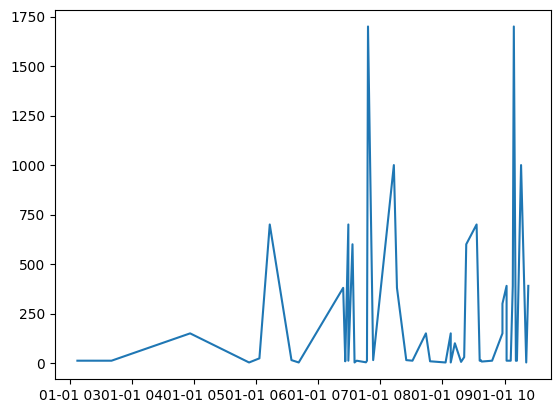

In [5]:
plt.plot(initial_df["OrderDate"].iloc[0:50], initial_df["Sales"].iloc[0:50])

In [6]:
initial_df["Product"].value_counts()

USB-C Charging Cable          21903
Lightning Charging Cable      21658
AAA Batteries (4-pack)        20641
AA Batteries (4-pack)         20577
Wired Headphones              18882
Apple Airpods Headphones      15549
Bose SoundSport Headphones    13325
27in FHD Monitor               7507
iPhone                         6842
27in 4K Gaming Monitor         6230
34in Ultrawide Monitor         6181
Google Phone                   5525
Flatscreen TV                  4800
Macbook Pro Laptop             4724
ThinkPad Laptop                4128
20in Monitor                   4101
Vareebadd Phone                2065
LG Washing Machine              666
LG Dryer                        646
Name: Product, dtype: int64

<Axes: >

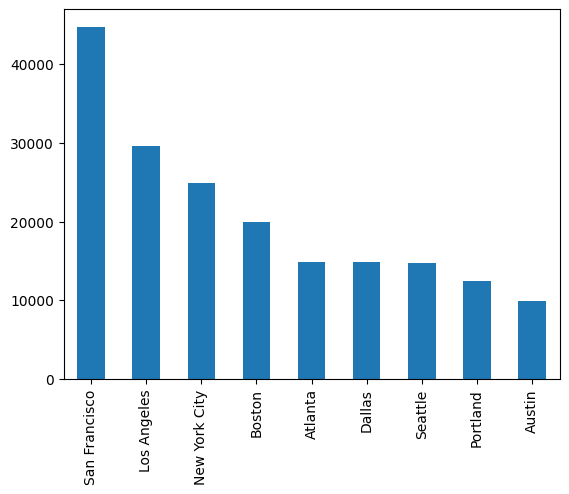

In [12]:
initial_df["CityName"].value_counts().plot(kind="bar")

<Axes: >

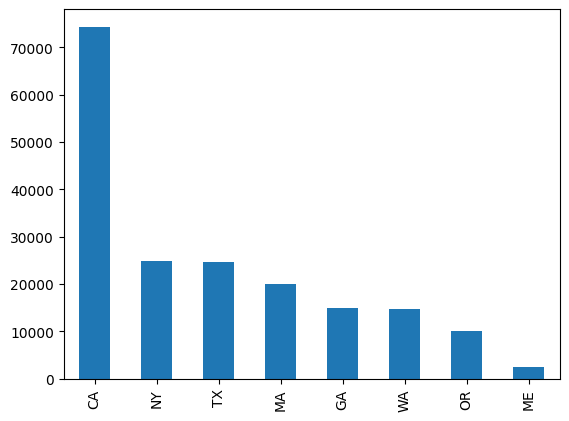

In [13]:
initial_df["StateCode"].value_counts().plot(kind="bar")

<Axes: >

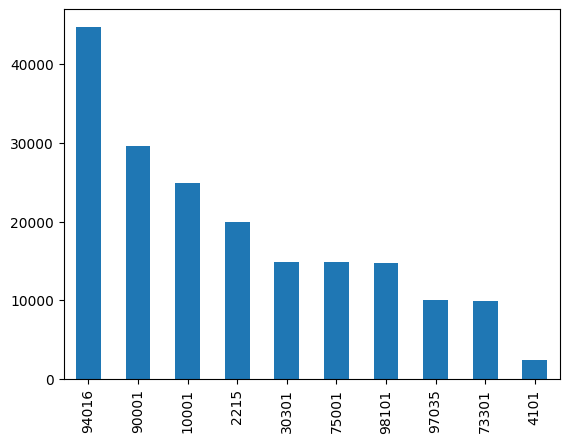

In [3]:
initial_df["ZipCode"].value_counts().plot(kind="bar")

In [4]:
df_by_day = initial_df.set_index(keys=["OrderDate"])

<Axes: xlabel='OrderDate'>

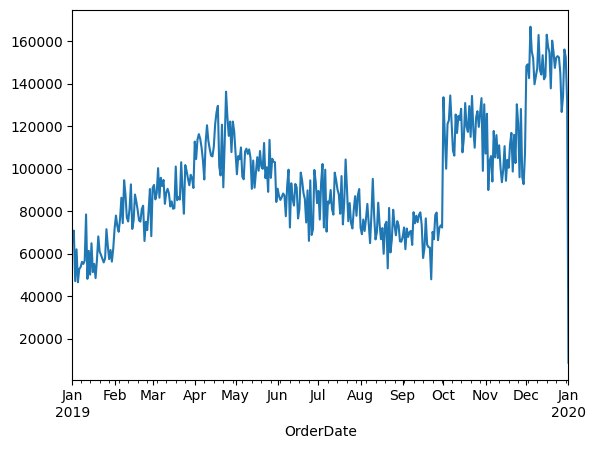

In [5]:
df_by_day["Sales"].resample("D").sum().plot()

In [199]:
# fig, ax = plt.subplots(figsize=(10, 6))
# df_by_day.boxplot(by="Hour", column="Sales", ax=ax)
# df_by_day.groupby('Hour')['Sales'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Sales')
# ax.set_title('Sales distribution by day')
# fig.suptitle('')
# plt.show();

In [200]:
# fig, ax = plt.subplots(figsize=(10, 6))
# df_by_day.boxplot(by="Month", column="Sales", ax=ax)
# df_by_day.groupby('Month')['Sales'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Sales')
# ax.set_title('Sales distribution by day')
# fig.suptitle('')
# plt.show();

In [6]:
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.preprocessing import TimeSeriesDifferentiator

In [68]:
X = df_by_day["Sales"].resample("H").sum()

In [80]:
X.loc["2019-01-01"].resample("D").sum()

OrderDate
2019-01-01    65681.94
Freq: D, Name: Sales, dtype: float64

In [81]:
X.loc["2020-01-01"].resample("D").sum()

OrderDate
2020-01-01    8670.29
Freq: D, Name: Sales, dtype: float64

In [70]:
diferenciator = TimeSeriesDifferentiator(order=2)
data_train = X.asfreq("H")
data_diff = diferenciator.fit_transform(data_train)
data_diff = pd.Series(data_diff, index=data_train.index).dropna()

Train dates : 2019-01-01 03:00:00 --- 2019-09-30 23:00:00  (n=6549)
Test dates  : 2019-09-30 00:00:00 --- 2020-01-01 05:00:00  (n=2238)


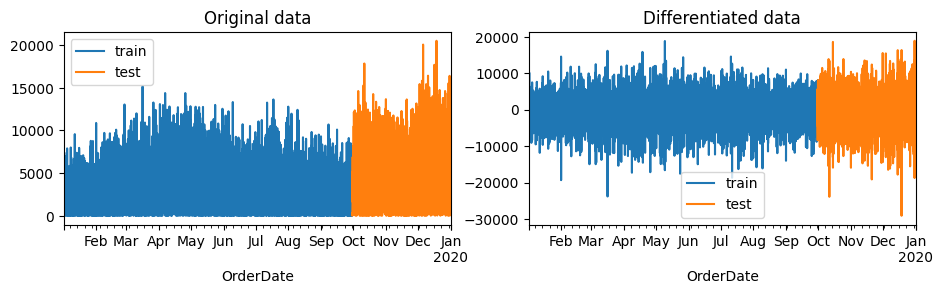

In [71]:
end_train = '2019-09-30'
print(
    f"Train dates : {data_train.index.min()} --- {data_train.loc[:end_train].index.max()}  " 
    f"(n={len(data_train.loc[:end_train])})")
print(
    f"Test dates  : {data_train.loc[end_train:].index.min()} --- {data_train.index.max()}  "
    f"(n={len(data_train.loc[end_train:])})")

# Plot
# ==============================================================================
fig, axs = plt.subplots(1, 2, figsize=(11, 2.5))
axs = axs.ravel()
data_train.loc[:end_train].plot(ax=axs[0], label='train')
data_train.loc[end_train:].plot(ax=axs[0], label='test')
axs[0].legend()
axs[0].set_title('Original data')

data_diff.loc[:end_train].plot(ax=axs[1], label='train')
data_diff.loc[end_train:].plot(ax=axs[1], label='test')
axs[1].legend()
axs[1].set_title('Differentiated data');

In [72]:
(X.index == pd.date_range(start=X.index.min(),
                             end=X.index.max(),
                             freq=X.index.freq)).all()

True

In [73]:
steps = len(data_train.loc[end_train:])

forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=24
)
forecaster.fit(y=data_diff)
predictions_rf=forecaster.predict(steps=steps)

In [74]:
data_diff.shape

(8761,)

In [75]:
from sklearn.metrics import mean_absolute_error
error_rf = mean_absolute_error(data_diff.loc[end_train:], predictions_rf)
print(f"Error (MAE) Random Forest: {error_rf:.2f}")

Error (MAE) Random Forest: 3738.81


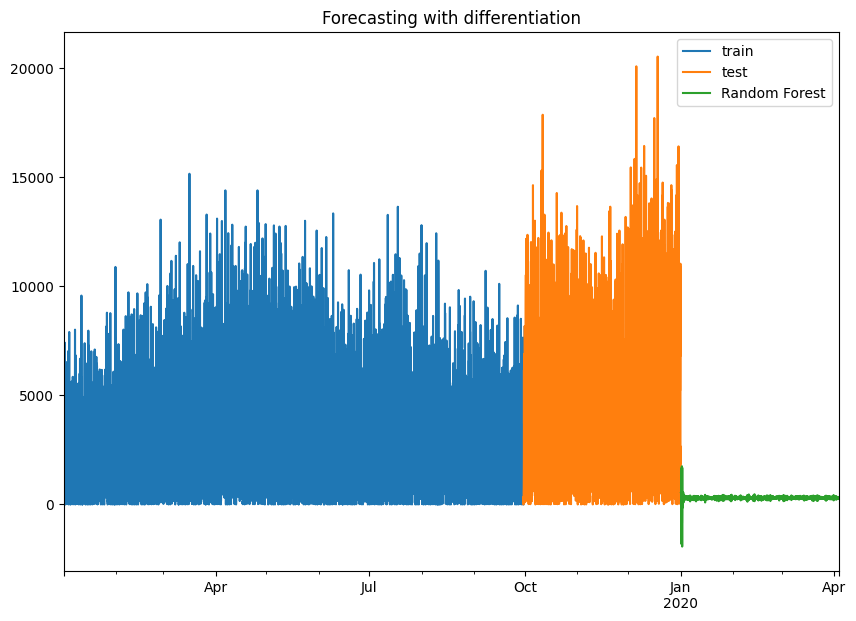

In [76]:
fig, ax = plt.subplots(figsize=(10, 7), sharex=True, sharey=True)
data_train.loc[:end_train].plot(ax=ax, label='train')
data_train.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Random Forest')
ax.set_title(f'Forecasting with differentiation')
ax.set_xlabel('')
ax.legend();

In [82]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster

In [104]:
y = df_by_day["Sales"].resample("D").sum()
y = y.drop(index=["2020-01-01"])

In [105]:
# step 1: data specification

# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=7)

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Sales'>)

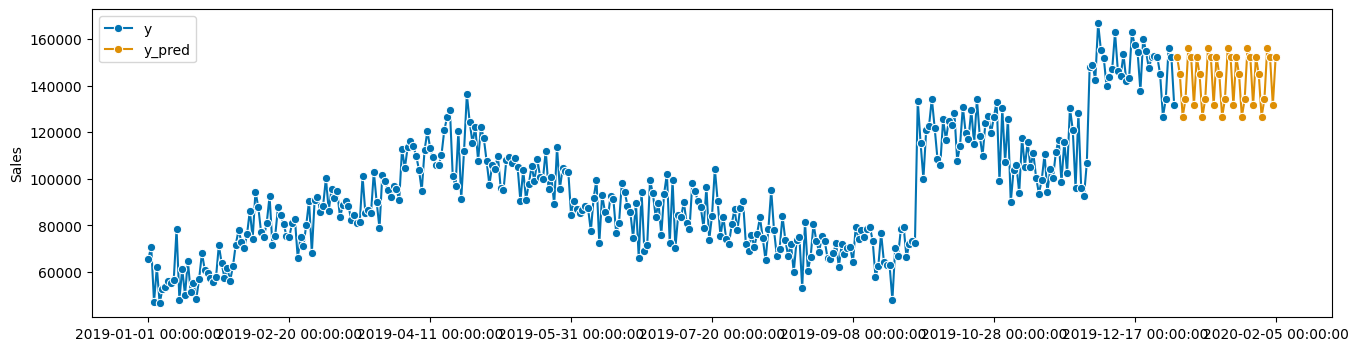

In [106]:
# optional: plotting predictions and past data
from sktime.utils.plotting import plot_series
plot_series(y, y_pred, labels=["y", "y_pred"])